## Content:
- [Exploration](#Exploration)
- [Apnea / RERA definitions](#Apnea-/-RERA-definitions)
- [Importing libraries](#Importing-libraries)
- [Setting paths to data (online/offline)](#Setting-paths-to-data)
- [Available signals](#Available-signals)
- [Exploring labels](#Exploring-labels)
- [Alignment of signals and labels](#Alignment-of-signals-and-labels)
- [Preparation for ML classification task](#Preparation-for-ML-classification-task)

# Exploration

>In this notebook, [wfdb API](https://github.com/MIT-LCP/wfdb-python) will be used to access [PhysioNet](https://physionet.org/) database. Some standard python packages will be used to display and prepare data for classification task. 
>
> We will be working with [Apnea/RERA](https://physionet.org/physiobank/database/challenge/2018/) clinical dataset. There are 994 patients in the training set, which has labels for sleep stages and arousals, and 989 patients in test set without labels. It is not necessary to download training dataset for exploration, but it is desirable for training neural network.
>
>In order to access data: 
>
> 1) One can download it to local directory either using [torrent](https://physionet.org/challenge/2018/training.torrent)   
> 2) `wget  -r -np -nH --cut-dirs=4 -R "index.html*" -e robots=off  "https://physionet.org/physiobank/database/challenge/2018/training/"`  
> 3) or access it through API [wfdb](https://github.com/MIT-LCP/wfdb-python)


# Apnea / RERA definitions

> The following plot give a very good visual definitions of Apnea and RERA events ([source](https://cp.neurology.org/content/4/1/44/tab-figures-data#fig-data-figures))  
> - If you are trying to create an Apnea classification ML model, you must understand how many signals will be required to input into ML model to be successful with classification task (binary vs. multilabel)
> - For example one can clearly see that Hypopnea and RERA could be distinguishable only if you have EEG signal  
> - Also you will be able to classify different Apnea events only if you used esophageal balloon during studies
> - For our mock-up case a simple binary Apnea classification task will be shown


![Apnea vs RERA](https://cp.neurology.org/content/neurclinpract/4/1/44/F1.large.jpg?download=true)

> ### More formal definitions of Apnea and RERA events are given in the table below ([source](http://cp.neurology.org/content/4/1/44.full.html))

Name                                  | Definitions of sleep-disordered breathing
--------------------------------------|------------------------------------------
Obstructive apnea Clinical definition| Apnea is defined as a cessation of airflow for at least 10 seconds. The event is obstructive if during apnea there is effort to breathe.  
Research definition| A clear decrease (.50%) from baseline in the amplitude of a valid measure of breathing during sleep lasting at least 10 seconds (note: little difference made between obstructive apnea or hypopnea).  
Central apnea Clinical definition| Apnea is defined as a cessation of airflow for at least 10 seconds. The event is central if during apnea there is no effort to breathe.  
Research definition| Same as above, but an esophageal balloon must verify lack of effort.   
Mixed apnea Clinical definition| Apnea is defined as a cessation of airflow for at least 10 seconds. The event is mixed if the apnea begins as central apnea but toward the end there is effort to breathe without airflow.  
Hypopnea Clinical definition| Several clinical definitions of hypopnea are in clinical use and there is no clear consensus. The Centers for Medicare & Medicaid Services–approved definition of hypopnea is an abnormal respiratory event with at least a 30% reduction in thoracoabdominal movement or airflow as compared to baseline lasting at least 10 seconds and with 4% oxygen desaturation. Obstruction is often inferred from thoracoabdominal paradox, the shape of the flow signal, or when snoring intensity increases during the event.
Research definition| A clear amplitude reduction of a validated measure of breathing during sleep (but less than 50% reduction from baseline) that is associated with an oxygen desaturation of 3% or an arousal. Only an esophageal balloon can definitively demonstrate the hypopnea to be obstructive vs central.
Cheyne-Stokes Clinical definition| Cheyne-Stokes respiration is a disorder characterized by recurrent central apneas during sleep with crescendo-decrescendo patterns of tidal volumes. It is often observed in patients with congestive heart failure. 
RERA (respiratory effort-related arousal) Research definition| Sequence of breaths with increasing respiratory effort leading to an arousal from sleep, as shown by progressively more negative esophageal pressure for at least 10 seconds preceding an arousal with resumption of more normal pressures.
Flow limitation Clinical definition| Airflow limitation can be inferred from subtle qualitative changes in the inspiratory portion of the respiratory signals and occurs as a result of increased esophageal pressure that is not accompanied by a flow increase.
Primary snoring Clinical definition| Noisy vibration of upper airway during sleep without associated alterations in sleep architecture. Upper airway resistance syndrome
Research definition| Airflow limitation with frequent arousals from sleep due to flow impairment. Positional sleep apnea Clinical definition: Apneas that occur mainly while sleeping in certain positions, particularly the supine position.


## Importing libraries

>An IPython magic extension for printing date and time stamps, version numbers, and hardware information. 
>[watermark](https://github.com/rasbt/watermark)

In [1]:
# Import of libraries for working with the data
import pandas as pd
import os
import wfdb
import numpy as np
# Additional libraries and settings for plotting 
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from scipy.signal import resample
# Fixing imbalanced classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
ROS = RandomOverSampler(sampling_strategy='minority', return_indices=True, random_state=1)
RUS = RandomUnderSampler(sampling_strategy='auto', return_indices=True, random_state=10)

In [2]:
%load_ext watermark
%watermark

2019-03-30T01:08:49-04:00

CPython 3.6.8
IPython 6.4.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit


In [3]:
%watermark --iversions

matplotlib 3.0.2
pandas     0.23.1
numpy      1.14.5
wfdb       2.0.2



In [4]:
#Setting up fonts for plotting
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 21
plt.rc('font', size=BIGGER_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Plotting parameters for better view
rcParams['figure.figsize'] = 36, 6
# Only used if Jupyter Theme is Dark
#rcParams['xtick.color'] = 'white'
#rcParams['ytick.color'] = 'white'

## Setting paths to data

> [RECORDS](https://physionet.org/physiobank/database/challenge/2018/training/RECORDS) file should be downloaded from PhysioNet and placed to [physio_data](../physio_data) folder. This file is needed regardless whether you access data online or offline 


In [5]:
# Path to folder with downloaded data for PhysioNet/CinC Challenge 2018 (https://physionet.org/physiobank/database/challenge/2018/)
# Training data can be downloaded using torrent or using wget  -r -np -nH --cut-dirs=4 -R "index.html*" -e robots=off "https://physionet.org/physiobank/database/challenge/2018/training/"
pathToDataDir = os.path.abspath('../physio_data/training/')
# Getting all training data records
dfCatalog = pd.read_csv((pathToDataDir+'/RECORDS'), header=None, names=['Folder'])

# Challenge name/location for wfdb package (https://github.com/MIT-LCP/wfdb-python), if data will be pulled from the web directly
challenge_name = 'challenge/2018/training/' 
dfCatalog.drop([40], inplace=True)
dfCatalog.drop([513], inplace=True)
# removing tr03-0394 and tr07-0023 no labels for apnea events
dfCatalog.reset_index(inplace=True)
dfCatalog.drop(['index'],axis=1,inplace=True)

# Available signals

>There are 13 signal channels available in this dataset: 

Signal Name|Units|Signal Description
-----------|-----|-------------------
SaO2|%|Oxygen saturation
ABD|µV|Electromyography, a measurement of abdominal movement
CHEST|µV|Electromyography, measure of chest movement
Chin1-Chin2|µV|Electromyography, a measure of chin movement
AIRFLOW|µV|A measure of respiratory airflow
ECG|mV|Electrocardiogram, a measure of cardiac activity
E1-M2|µV|Electrooculography, a measure of left eye activity
O2-M1|µV|Electroencephalography, a measure of posterior activity
C4-M1|µV|Electroencephalography, a measure of central activity
C3-M2|µV|Electroencephalography, a measure of central activity
F3-M2|µV|Electroencephalography, a measure of frontal activity
F4-M1|µV|Electroencephalography, a measure of frontal activity
O1-M2|µV|Electroencephalography, a measure of posterior activity
>
>Excluding SaO2, all signals were sampled to 200 Hz and were measured in microvolts. For analytic convenience, SaO2 was resampled to 200Hz, and is measured as a [percentage](https://physionet.org/physiobank/database/challenge/2018/)

In [6]:
#Patient id is relative to RECORDS file
patientID = 0
# Available channels/signals
chan_dict = {'F3-M2':0, 'F4-M1':1, 'C3-M2':2, 'C4-M1':3, 'O1-M2':4,
             'O2-M1':5, 'E1-M2':6, 'Chin1-Chin2':7, 'ABD':8, 'CHEST':9, 
             'AIRFLOW':10, 'SaO2':11, 'ECG':12}
# Here you can specify which channels and order, you would like it to be extract from the database
channels=[9, 8, 11, 12, 10]

## Exploring labels

>Online data pull:

In [7]:
# Getting labels
# Should be used when labels pulled from the web
labels = wfdb.rdann(os.path.split(dfCatalog['Folder'].iloc[patientID])[0], pb_dir='{0}/{1}/'.format(challenge_name ,os.path.split(dfCatalog['Folder'].iloc[patientID])[0]), extension='arousal')  

# Getting signals
# Should be used when signals pulled from the web
signals, fields = wfdb.rdsamp(os.path.split(dfCatalog['Folder'].iloc[patientID])[0],pb_dir='{0}/{1}/'.format(challenge_name ,os.path.split(dfCatalog['Folder'].iloc[patientID])[0]), channels=channels) 


>For offline labels and signals load, uncomment below

In [8]:
#labels = wfdb.rdann(pathToDataDir+'/{0}/{0}'.format(os.path.split(dfCatalog['Folder'].iloc[patientID])[0]), extension='arousal') # Should be used when labels stored locally
#signals, fields = wfdb.rdsamp(pathToDataDir+'/{0}/{0}'.format(os.path.split(dfCatalog['Folder'].iloc[patientID])[0]), channels=channels) # Should be used when signals stored locally

> Default wfdb package is very useful and anyone who wants to start using PhysioNet should get him/herself familiar with this tutorial [notebook](https://github.com/MIT-LCP/wfdb-python/blob/master/demo.ipynb)

In [9]:
# Show the signals and metadata
display(signals)
display(fields)

array([[-2.00000000e+00, -4.10000000e+01,  9.65346761e+01,
        -5.30000000e-02,  3.90000000e+01],
       [ 0.00000000e+00, -3.60000000e+01,  9.65346761e+01,
        -1.03000000e-01,  9.30000000e+01],
       [ 3.00000000e+00, -2.70000000e+01,  9.65346761e+01,
         6.00000000e-03,  6.20000000e+01],
       ...,
       [-1.07000000e+02,  0.00000000e+00,  4.95918212e-01,
         5.43000000e-01, -6.00000000e+00],
       [-1.06000000e+02,  0.00000000e+00,  4.95918212e-01,
        -7.28000000e-01,  3.00000000e+00],
       [-1.06000000e+02,  0.00000000e+00,  4.95918212e-01,
        -7.20000000e-02,  4.00000000e+00]])

{'fs': 200,
 'sig_len': 5147000,
 'n_sig': 5,
 'units': ['uV', 'uV', '%', 'mV', 'uV'],
 'sig_name': ['CHEST', 'ABD', 'SaO2', 'ECG', 'AIRFLOW'],
 'comments': []}

> **For binary RERA / Not RERA classification, one can use these labels:**


In [10]:
labels.chan

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [11]:
#Timestamps for Apnea/RERA events
labels.sample[:20]

array([ 72000, 120000, 124524, 127604, 132000, 138000, 156000, 168000,
       172524, 174000, 176284, 183186, 186000, 186006, 192904, 196364,
       199652, 203231, 216000, 228000])

> In case someone is interested in other labels such as:
> -  wakefulness, stage 1, stage 2, stage 3, rapid eye movement (REM), and undefined  
> or  
> -  spontaneous arousals, respiratory effort related arousals (RERA), bruxisms, hypoventilations, hypopneas, apneas (central, obstructive and mixed), vocalizations, snores, periodic leg movements, Cheyne-Stokes breathing or partial airway obstructions 
>  
> the following command can be used to extract them all `labels.aux_note`
>  
> **It should be mentioned that for Apnea/RERA all labels shows start "(" and an end ")" of the event, while for Sleep Stages it just shows the begining of the event**

In [12]:
(labels.aux_note)[:20]

['W',
 'N1',
 '(resp_centralapnea',
 'resp_centralapnea)',
 'W',
 'N1',
 'N2',
 'W',
 '(resp_centralapnea',
 'N1',
 'resp_centralapnea)',
 '(resp_centralapnea',
 'N2',
 'resp_centralapnea)',
 '(arousal_rera',
 'arousal_rera)',
 '(arousal_rera',
 'arousal_rera)',
 'W',
 'N1']

>**We will need a dictionary to correctly extract all labels**

In [13]:
# Apnea / RERA dictionary
rera_dict = {'(arousal_bruxism':11,
 '(arousal_noise':13,
 '(arousal_plm':10,
 '(arousal_rera':8,
 '(arousal_snore':12,
 '(arousal_spontaneous':9,
 '(resp_centralapnea':4,
 '(resp_cheynestokesbreath':7,
 '(resp_hypopnea':1,
 '(resp_hypoventilation':6,
 '(resp_mixedapnea':5,
 '(resp_obstructiveapnea':2,
 '(resp_partialobstructive':3,
 'N1':None,
 'N2':None,
 'N3':None,
 'R':None,
 'W':None,
  'arousal_bruxism)':0,
 'arousal_noise)':0,
 'arousal_plm)':0,
 'arousal_rera)':0,
 'arousal_snore)':0,
 'arousal_spontaneous)':0,
 'resp_centralapnea)':0,
 'resp_cheynestokesbreath)':0,
 'resp_hypopnea)':0,
 'resp_hypoventilation)':0,
 'resp_mixedapnea)':0,
 'resp_obstructiveapnea)':0,
 'resp_partialobstructive)':0}
# Sleep stage dictionary
stage_dict = {
 'N1':1,
 'N2':2,
 'N3':3,
 'R':4,
 'W':0}

## Alignment of signals and labels 

> Combining Apnea/RERA labels with signals for binary or multiclass classification  
> Loading labels into DataFrame

In [14]:
dfL = pd.DataFrame(labels.aux_note, index=labels.sample, columns=['all_events'])
dfL.head(3)

,all_events
72000,W
120000,N1
124524,(resp_centralapnea


> Mapping Apnea/RERA events data  
> Mapping Sleep Stage events will be shown separately 

In [15]:
dfL['apnea_rera']  = dfL['all_events'].map(rera_dict)
dfL.head(3)

,all_events,apnea_rera
72000,W,NaN
120000,N1,NaN
124524,(resp_centralapnea,4.0


> Filling NaN values, the order/method is important since labels that corresponded to an end of the event were set to 0 in the dictionary

In [16]:
dfL['apnea_rera'].fillna(method = 'ffill', inplace=True)
dfL['apnea_rera'].fillna(value = 0, inplace=True)
dfL.head(5)

,all_events,apnea_rera
72000,W,0.0
120000,N1,0.0
124524,(resp_centralapnea,4.0
127604,resp_centralapnea),0.0
132000,W,0.0


> Converting to one-hot encoded labels

In [17]:
dfLabelsCat = pd.DataFrame(columns=range(14))
dfLabelsCat = dfLabelsCat.append(pd.get_dummies(dfL['apnea_rera']))

> Adding index 0 for correct `fillna` with `method='ffill'` when labels will be merged with signals

In [18]:
dfLabelsCat.loc[0] = 0
dfLabelsCat = dfLabelsCat.sort_index(ascending=True)
dfLabelsCat.fillna(value=0, inplace=True)
dfLabelsCat.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72000,1,0,0,0,0,0,0,0,0,0,0,0,0,0
120000,1,0,0,0,0,0,0,0,0,0,0,0,0,0
124524,0,0,0,0,1,0,0,0,0,0,0,0,0,0
127604,1,0,0,0,0,0,0,0,0,0,0,0,0,0


> Combining signals with labels and filling gaps

In [19]:
df = pd.DataFrame(data=signals, columns=fields['sig_name'])
df = df.join(dfLabelsCat)
df.fillna(method='ffill', inplace=True)
df.fillna(value=0, inplace=True)
df.drop(columns=0, inplace=True)

In [20]:
df.head()

,CHEST,ABD,SaO2,ECG,AIRFLOW,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-2.0,-41.0,96.534676,-0.053,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-36.0,96.534676,-0.103,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,-27.0,96.534676,0.006,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,-17.0,96.534676,0.058,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.0,-8.0,96.534676,-0.064,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> In order to classify sleep stages, the steps to combine labels and signals will be similar, but you will need to use `stage_dict`  
> Let's plot some signals

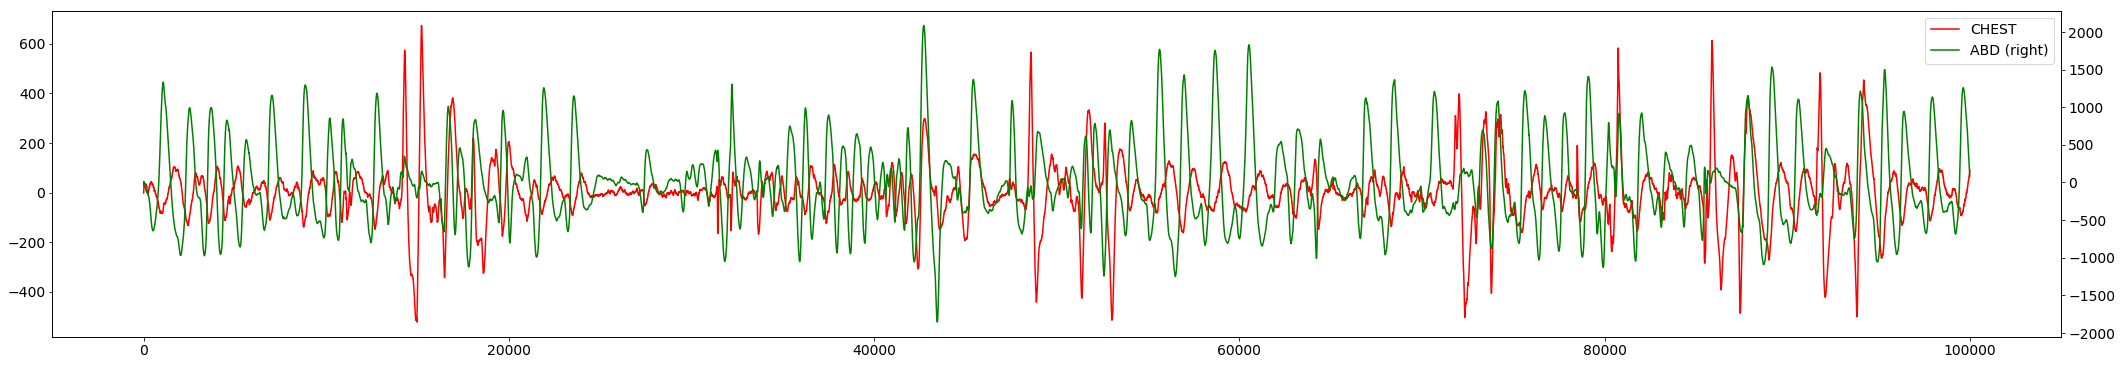

In [21]:
df.CHEST.loc[0:100000].plot(style='r', legend=True)
df.ABD.loc[0:100000].plot(style='g', legend=True, secondary_y=True)

> As it can be seen all signals are at different scales, we will need to correct it and scale every signal from 0 to 1

In [22]:
df.CHEST.describe()

count    5.147000e+06
mean    -1.700097e-02
std      1.109597e+02
min     -2.632000e+03
25%     -3.400000e+01
50%      1.000000e+00
75%      3.900000e+01
max      2.900000e+03
Name: CHEST, dtype: float64

In [23]:
df.ABD.describe()

count    5.147000e+06
mean    -6.132699e-03
std      3.395611e+02
min     -4.075000e+03
25%     -1.950000e+02
50%      0.000000e+00
75%      1.600000e+02
max      3.945000e+03
Name: ABD, dtype: float64

In [24]:
df.ECG.describe()

count    5.147000e+06
mean    -2.172139e-07
std      3.110605e-01
min     -4.219000e+00
25%     -1.910000e-01
50%      0.000000e+00
75%      1.910000e-01
max      4.163000e+00
Name: ECG, dtype: float64

> Let's plot Chest respiration signal along with Apnea/RERA events

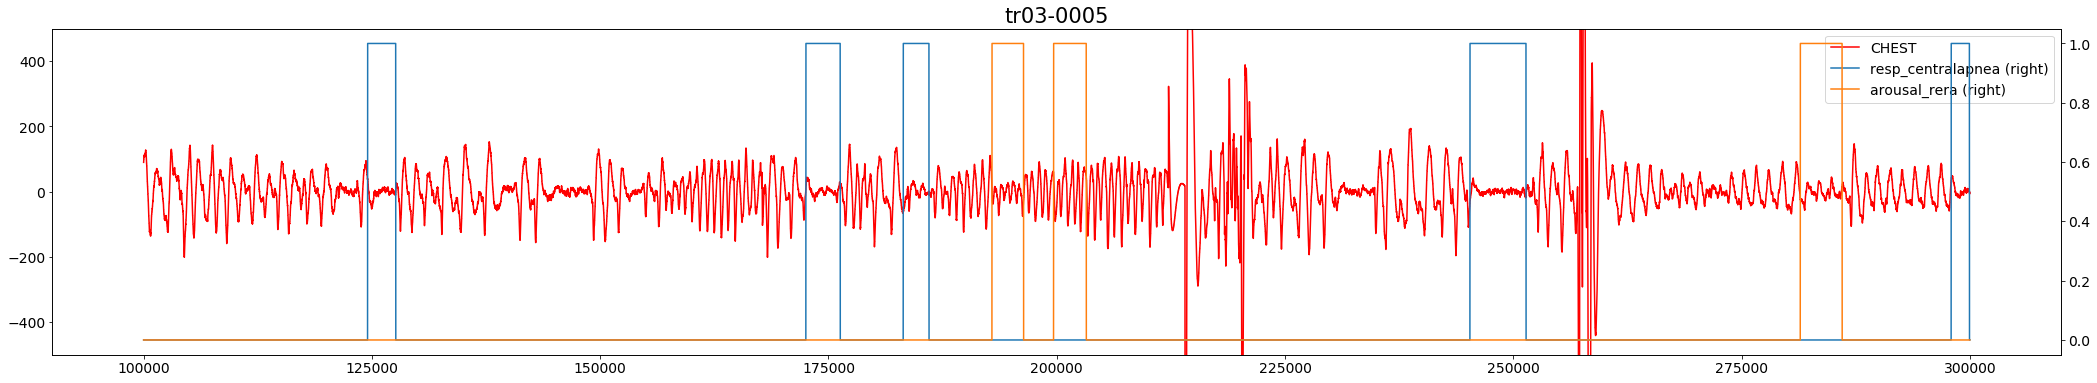

In [25]:
plt.title((dfCatalog['Folder'].iloc[patientID])[:-1])
df.CHEST.loc[100000:300000].plot(style='r', legend=True)
plt.ylim(-500,500)
df[4].loc[100000:300000].plot(legend=True, secondary_y=True, label=list(rera_dict.keys())[list(rera_dict.values()).index(4)][1:])
df[8].loc[100000:300000].plot(legend=True, secondary_y=True, label=list(rera_dict.keys())[list(rera_dict.values()).index(8)][1:])

# Preparation for ML classification task

> To prepare data for classification task, we will reshape signals into intervals of fixed lenght and scale data between 0 and 1.

In [26]:
# Sampling frequency 
labels.fs 

200

In [27]:
samplingRateInHz = labels.fs # Initial sampling rate 200 Hz
bufferSizeInSec = 60 # 1 minute intervals that will be classified Apnea no Apnea
trainData = df.values
batch = np.array(trainData[:((trainData.shape[0]//(samplingRateInHz*bufferSizeInSec))*(samplingRateInHz*bufferSizeInSec))]).reshape((-1,samplingRateInHz*bufferSizeInSec,trainData.shape[1]))

In [28]:
batch.shape

(428, 12000, 18)

In [29]:
# Setting number of signal channels
numberOfChannels = fields['n_sig']

In [30]:
# Spliting to labels and signals
x = np.nan_to_num(batch[:,:,:numberOfChannels])
y = np.nan_to_num((batch[:,:,numberOfChannels:]).max(axis=1))

> Ploting SaO2 level, since we will be using this signal in ML model we need to remove any signal level which dropped significantly 

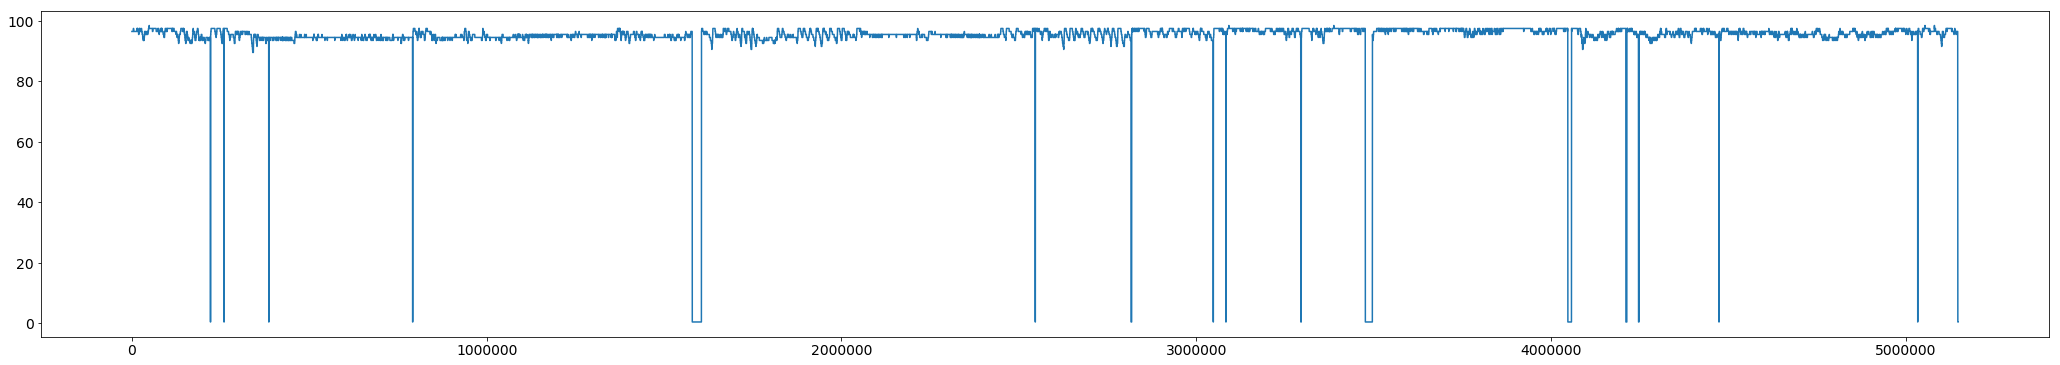

In [31]:
df.SaO2.plot()

In [32]:
# Removing signals where SaO2 level dropped below 50%
y = np.delete(y, list(set(np.nonzero((x[:,:,2]<50))[0])), axis=0)
x = np.delete(x, list(set(np.nonzero((x[:,:,2]<50))[0])), axis=0)

In [33]:
x.shape

(406, 12000, 5)

> Scalling signals between 0 and 1

In [34]:
for j in range(x.shape[0]):
    x[j,:,0] = (x[j,:,0] - x[j,:,0].min(axis=0)) /np.nanmax(np.ptp(x[j,:,0], axis=0))
    x[j,:,1] = (x[j,:,1] - x[j,:,1].min(axis=0)) /np.nanmax(np.ptp(x[j,:,1], axis=0))
    x[j,:,3] = (x[j,:,3] - x[j,:,3].min(axis=0)) /np.nanmax(np.ptp(x[j,:,3], axis=0))
    x[j,:,4] = (x[j,:,4] - x[j,:,4].min(axis=0)) /np.nanmax(np.ptp(x[j,:,4], axis=0))
    x[j,:,2] /= 100  # SaO2 scalling between 0 and 1

In [35]:
# Checking if any signal is nan or inf
for ch in range(5):
    y = np.delete(y, list(set(np.nonzero((x[:,:,ch]==np.nan))[0])), axis=0)
    x = np.delete(x, list(set(np.nonzero((x[:,:,ch]==np.nan))[0])), axis=0)
    y = np.delete(y, list(set(np.nonzero((x[:,:,ch]==np.inf))[0])), axis=0)
    x = np.delete(x, list(set(np.nonzero((x[:,:,ch]==np.inf))[0])), axis=0)
x = np.nan_to_num(x)
y = np.nan_to_num(y)

In [36]:
x.shape

(406, 12000, 5)

In [37]:
# Additionally if only binary classification is needed, then labels become
y = y[:,:].max(axis=1)

In [38]:
# If we check how many Apnea events in total we have, then it is apparent that classes are imbalanced
y.sum()/y.shape[0]

0.18472906403940886

In [39]:
# To balance classes we can oversample or undersample 
#_, _, ind = ROS.fit_sample(x[:,:,0], y[:])
_, _, ind = RUS.fit_sample(x[:,:,0], y[:])
np.random.shuffle(ind)
x = x[ind]
y = y[ind]

In [40]:
# Now classes are balanced
y.sum()/y.shape[0]

0.5

In [41]:
y.shape[0]

150

In [42]:
# We don't need 200 Hz sampling frequency and can downsample it to lower frequencies
newSamplingRateInHz = 100
x = resample(x, int(bufferSizeInSec*newSamplingRateInHz), axis=1)

In [43]:
x.shape

(150, 6000, 5)

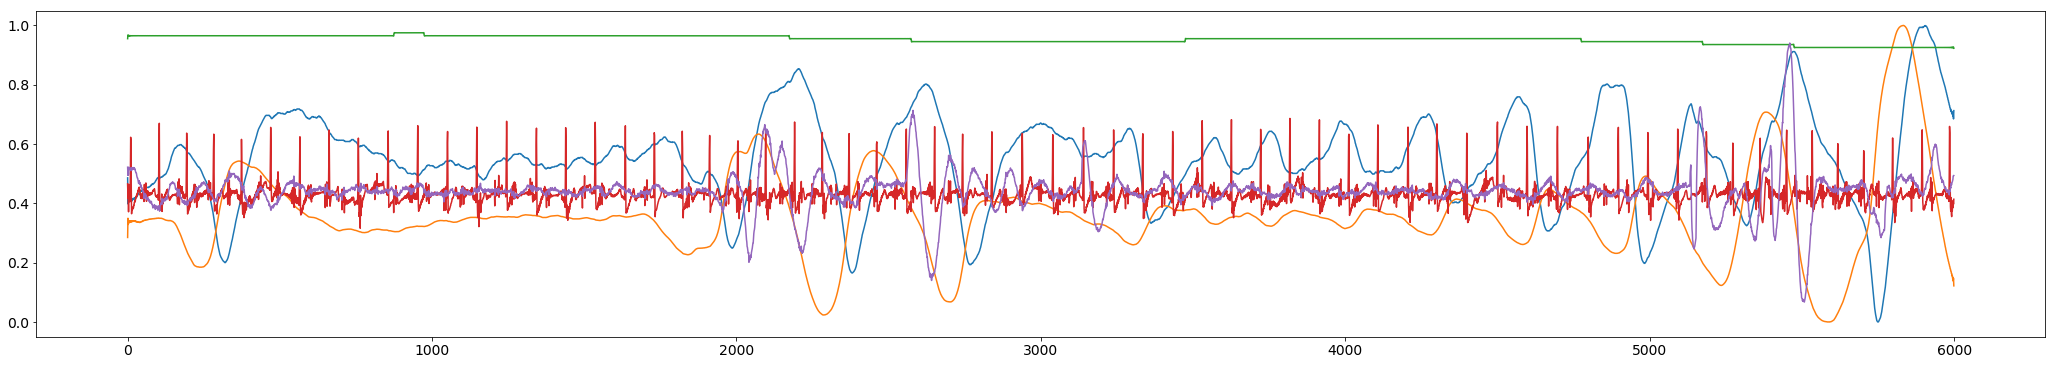

In [44]:
# Plotting scaled data
plt.plot(x[70])

-----------------------------------

> At this point the data is ready to be feeded into ML classification algorithm. This is what we will do in the [second notebook](2_Model_training.ipynb)